In [1]:
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from IPython.display import Image
import tensorflow as tf

2024-09-14 08:09:13.538095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 08:09:13.538116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 08:09:13.539219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 08:09:13.545862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 08:09:15.994816: W tensorflow/compiler/tf2

In [2]:
from omnifold import DataLoader, MultiFold, MLP, SetStyle, HistRoutine

Horovod instalation found.


# OmniFold example using high-level features as inputs

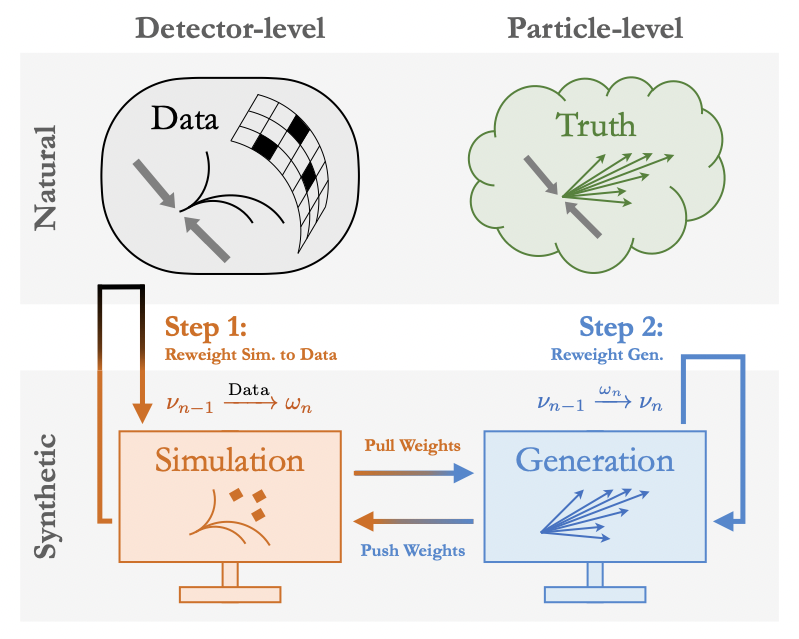

In [3]:
Image(filename='Omnifold.png')

In [4]:
def detector(x,std = 0.5):
    """ Create a fake detector response that smears the inputs given a gaussian distribution with mean 0 and std"""
    return x + np.random.normal(size=x.shape)*std

In [5]:
nevts = 1_000_000 #Number of training events we are going to use
ndim = 4 #Number of features we are going to create

In [6]:
gen_data = np.random.normal(size=(nevts,ndim),loc=ndim*[0.0],scale=ndim*[1.0])
reco_data = detector(gen_data)
gen_mc = np.random.normal(size=(nevts,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
reco_mc = detector(gen_mc)

data = DataLoader(reco = reco_data,normalize=True)
mc = DataLoader(reco = reco_mc,gen = gen_mc,normalize=True)

INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...


## Let's take a quick look at the data

(<Figure size 900x900 with 2 Axes>,
 <Axes: ylabel='Normalized number of events'>)

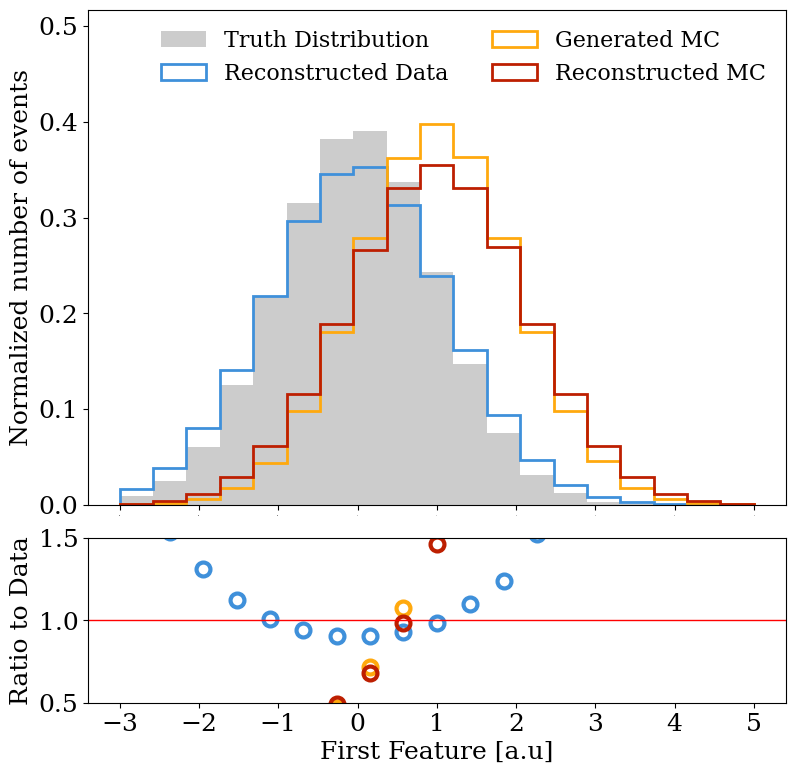

In [7]:
SetStyle()
data_dict = {
    'Truth Distribution': gen_data[:,0],
    'Reconstructed Data': reco_data[:,0],
    'Generated MC': gen_mc[:,0],
    'Reconstructed MC': reco_mc[:,0],
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'Truth Distribution',plot_ratio=True, binning = np.linspace(-3,5,20),)

## Let's now create the neural network models we are going to use to model the weight distributions

In [8]:
model1 = MLP(ndim)
model2 = MLP(ndim)

2024-09-14 08:09:24.560148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37064 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-09-14 08:09:24.561895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37970 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-09-14 08:09:24.563377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 37970 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2024-09-14 08:09:24.564902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37970 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [9]:
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Let's now unfold!

In [10]:
omnifold = MultiFold(
    "Gaussian_test",
    model1,
    model2,
    data,
    mc,
    batch_size = 512,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights',
    verbose = True,
    lr = 5e-5,
)

In [11]:
omnifold.Unfold()

3906 training steps at reco and 3906 steps at gen
ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 1999872, Test events used: 399974
################################################################################
Epoch 1/100


2024-09-14 08:09:30.935673: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3ab8dbb320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-14 08:09:30.935691: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-14 08:09:30.935695: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-14 08:09:30.935698: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-14 08:09:30.935701: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-14 08:09:30.941518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-14 08:0

3124/3124 [==============================] - 18s 4ms/step - loss: 0.4256 - val_loss: 0.4054 - lr: 5.0000e-05
Epoch 2/100
3124/3124 [==============================] - 13s 4ms/step - loss: 0.4049 - val_loss: 0.4053 - lr: 5.0000e-05
Epoch 3/100
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4049 - val_loss: 0.4052 - lr: 5.0000e-05
Epoch 4/100
3124/3124 [==============================] - 13s 4ms/step - loss: 0.4048 - val_loss: 0.4053 - lr: 5.0000e-05
Epoch 5/100
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4048 - val_loss: 0.4053 - lr: 5.0000e-05
Epoch 6/100
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4048 - val_loss: 0.4053 - lr: 5.0000e-05
Epoch 7/100
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4048 - val_loss: 0.4052 - lr: 5.0000e-05
Epoch 8/100
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4048 - val_loss: 0.4052 - lr: 5.0000e-05
Epoch 9/100
3124/3124 [=====================

## Now, let's evaluate the model!

In [12]:
validation_data = np.random.normal(size=(5*nevts,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
unfolded_weights  = omnifold.reweight(validation_data,omnifold.model2,batch_size=1000)   

5000/5000 [==============================] - 4s 735us/step


In [13]:
print(unfolded_weights)

[0.02978669 0.01063846 0.01132354 ... 0.0397895  0.01540451 1.3332595 ]


## More plots!

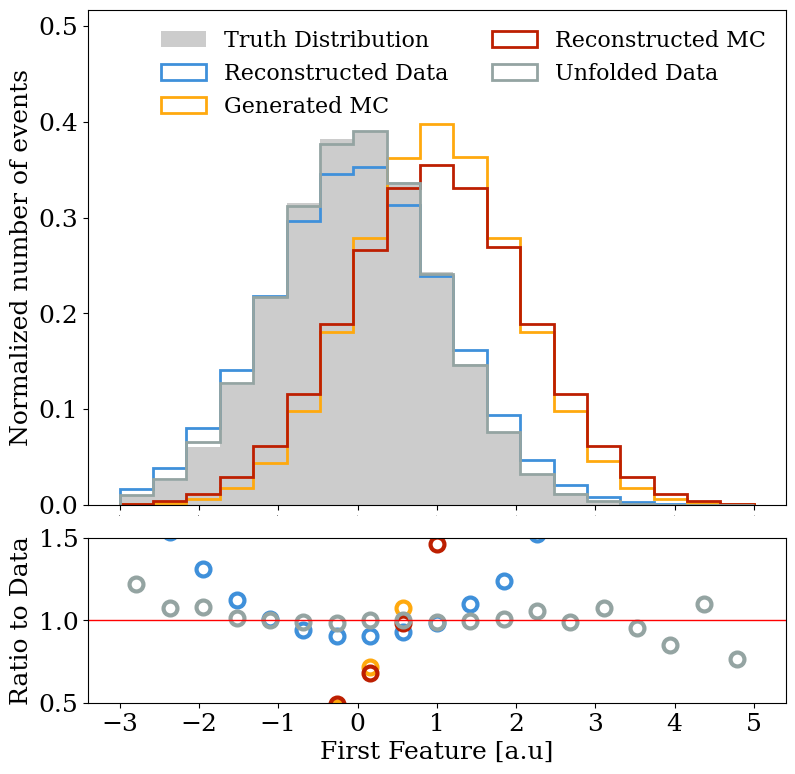

In [14]:
data_dict = {
    'Truth Distribution': gen_data[:,0],
    'Reconstructed Data': reco_data[:,0],
    'Generated MC': gen_mc[:,0],
    'Reconstructed MC': reco_mc[:,0],
    'Unfolded Data': validation_data[:,0],
}

weight_dict = {
    'Truth Distribution': data.weight,
    'Reconstructed Data': data.weight,
    'Generated MC': mc.weight,
    'Reconstructed MC': mc.weight,
    'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,'First Feature [a.u]',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = np.linspace(-3,5,20)
                    )
